In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Определение статистик

In [3]:
# Ско
def sigma(x):
    return np.std(x, ddof=1)

# Среднее абсолютное отклонение (mae)
def mae(x):
    return (np.sum(np.abs(x - np.mean(x))))/ (len(x) - 1)

# MAD — медиана абсолютных отклонений
def mad(x):
    return np.median(np.abs(x - np.median(x)))

# Статистика Граббса
def grubbs_statistic(x):
    s = sigma(x)
    return np.max(np.abs(x - np.mean(x))) / s


### генерация исходной совокупности и векторов погрешностей по заданию


In [4]:
def make_base_sample(seed=0):
    rng = np.random.default_rng(seed)
    x99 = rng.uniform(-1, 1, size=9)
    x100 = np.array([1.687])  
    return np.concatenate([x99, x100])

def make_delta_vector(x, rel_default=0.01, rel_last=0.01):
    deltas = np.zeros_like(x)
    deltas[:-1] = rel_default * np.abs(x[:-1])
    deltas[-1] = rel_last * abs(x[-1])
    return deltas


### аналитические границы Δy для всех статистик

In [5]:
# ско
def delta_sigma_strict(x, deltas):
    n = len(x)
    x_mean = np.mean(x)
    s = sigma(x)

    ds = (1 / ((n - 1) * s)) * np.sum(np.abs(x - x_mean) * deltas)

    return s - ds, s + ds, ds

# mae
def delta_mae_strict(x, deltas):
    n = len(x)

    dm = (1/(n-1)) * np.sum(np.abs(np.sign(x - np.mean(x))-np.mean(np.sign(x - np.mean(x)))) * deltas)

    return mae(x) - dm, mae(x) + dm, dm

# Статистика критерия Граббса
def delta_grubbs_strict(x, deltas):
    n = len(x)
    x_mean = np.mean(x)
    s = sigma(x)
    
    if s == 0:
        return 0, 0, 0
    
    # Номинальный G
    G = grubbs_statistic(x)
    
    # Индекс максимального отклонения
    deviations = np.abs(x - x_mean)
    k = np.argmax(deviations)
    
    # Производные для формулы Граббса
    x_k = x[k]
    
    # dG/dx_i для всех i
    dG_dx = np.zeros(n)
    
    for i in range(n):
        if i == k:
            # Производная по выбросу
            dG_dx[i] = (1/s) * np.sign(x_k - x_mean) * (1 - 1/n - (x_k - x_mean)**2/((n-1)*s**2))
        else:
            # Производная по остальным точкам
            dG_dx[i] = (1/(n*s)) * (-np.sign(x_k - x_mean) - (x_k - x_mean)*(x[i] - x_mean)/((n-1)*s**2))
    
    # Максимальное изменение G
    dG = np.sum(np.abs(dG_dx) * deltas)
    
    return G - dG, G + dG, dG

# Медиана абсолютного отклонения
def delta_mad_strict(x, deltas):
    n = len(x)

    l = x - deltas
    r = x + deltas

    L_med = np.median(l)
    R_med = np.median(r)

    gamma_lo = np.minimum(np.abs(l - R_med), np.abs(r - L_med))
    gamma_hi = np.maximum(np.abs(l - R_med), np.abs(r - L_med))

    y_lo = np.median(gamma_lo)
    y_hi = np.median(gamma_hi)

    # номинальный MAD
    mad0 = np.median(np.abs(x - np.median(x)))

    # # максимальное отклонение
    d = max(abs(mad0 - y_lo), abs(mad0 - y_hi))

    return y_lo, y_hi, d

# предельное значение Δy 
def analytic_delta_y(x, deltas):
    nom = {
        'sigma': sigma(x),
        'mae': mae(x),
        'grubbs': grubbs_statistic(x),
        'mad': mad(x)
    }
    bounds = {
        'sigma': delta_sigma_strict(x, deltas),
        'mae': delta_mae_strict(x, deltas),
        'grubbs': delta_grubbs_strict(x, deltas),
        'mad': delta_mad_strict(x, deltas)
    }

    result = {}
    for key in nom:
        lo, hi = bounds[key]
        result[key] = {
            'nom': nom[key],
            'min': lo,
            'max': hi,
            'delta': max(abs(nom[key] - lo), abs(nom[key] - hi))
        }
    return result


### Функция Монте-Карло: возвращает номиналы и max отклонение (|y_sample - y_nom|)

### 

In [ ]:
def monte_carlo_delta_y_lab6(x, deltas, N=100000, seed=0, progress=False):
    rng = np.random.default_rng(seed)

    y_nom = {
        'sigma': sigma(x),
        'mae': mae(x),
        'grubbs': grubbs_statistic(x),
        'mad': mad(x)
    }
    max_dev = {k: 0.0 for k in y_nom}

    iterator = range(N)
    if progress:
        iterator = tqdm(iterator)

    for _ in iterator:
        eps = np.random.uniform(-1.0, 1.0, size=len(x)) * deltas
        x_sample = x + eps

        y_sample = {
            'sigma': sigma(x_sample),
            'mae': mae(x_sample),
            'grubbs': grubbs_statistic(x_sample),
            'mad': mad(x_sample),
        }

        for stat in y_nom:
            d = abs(y_sample[stat] - y_nom[stat])
            if d > max_dev[stat]:
                max_dev[stat] = d

    return y_nom, max_dev


def analytic_delta_y_strict(x, deltas):
    s_lo, s_hi, s_d = delta_sigma_strict(x, deltas)
    mae_lo, mae_hi, mae_d = delta_mae_strict(x, deltas)
    gr_lo, gr_hi, gr_d = delta_grubbs_strict(x, deltas)
    mad_lo, mad_hi, mad_d = delta_mad_strict(x, deltas)

    return {
        'sigma': {'nom': sigma(x), 'min': s_lo, 'max': s_hi, 'delta': s_d},
        'mae':   {'nom': mae(x),   'min': mae_lo, 'max': mae_hi, 'delta': abs(mae_d)},
        'grubbs':{'nom': grubbs_statistic(x), 'min': gr_lo, 'max': gr_hi, 'delta': gr_d},
        'mad':   {'nom': mad(x),   'min': mad_lo, 'max': mad_hi, 'delta': mad_d},
    }

### основной эксперимент (аналитика + Монте-Карло) 

In [7]:
# Параметры эксперимента
rel_last_values = np.linspace(0.01, 0.20, 20)  # 1%..20%
rel_default = 0.01
N_mc = 10000

# если x0 уже определён — используем его, иначе создадим
try:
    x0
except NameError:
    x0 = make_base_sample(seed=22)

# номинальные значения
print("Номинальные значения (исходная совокупность):")
print(f"sigma = {sigma(x0):.6f}")
print(f"MAE   = {mae(x0):.6f}")
print(f"Grubbs= {grubbs_statistic(x0):.6f}")
print(f"MAD   = {mad(x0):.6f}")

# подготовка контейнеров
analytic_res = {s: [] for s in ['sigma','mae','grubbs','mad']}
mc_res = {s: [] for s in ['sigma','mae','grubbs','mad']}

# перебор rel_last
for rel_last in rel_last_values:
    deltas = make_delta_vector(x0, rel_default=rel_default, rel_last=rel_last)

    # аналитическая оценка 
    an = analytic_delta_y_strict(x0, deltas)
    for s in analytic_res:
        analytic_res[s].append(an[s]['delta'])

    # Монте-Карло оценка
    _, max_dev = monte_carlo_delta_y_lab6(x0, deltas, N=N_mc, seed=1, progress=False)
    for s in mc_res:
        mc_res[s].append(max_dev[s])


Номинальные значения (исходная совокупность):
sigma = 0.848570
MAE   = 0.779538
Grubbs= 1.790572
MAD   = 0.652273


### построение графиков

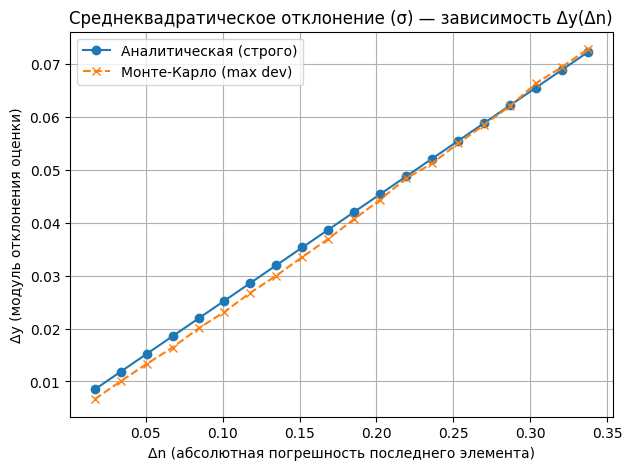

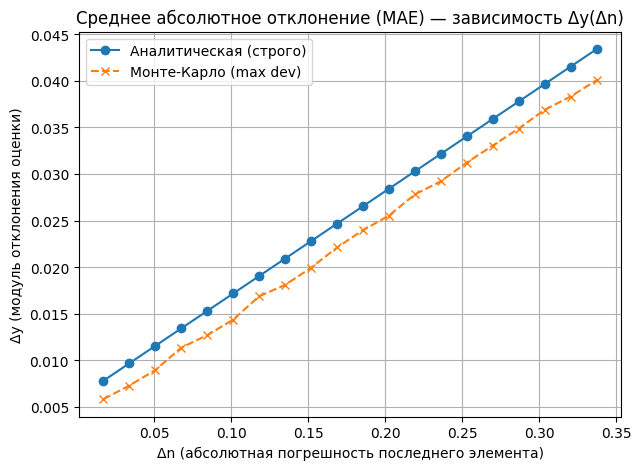

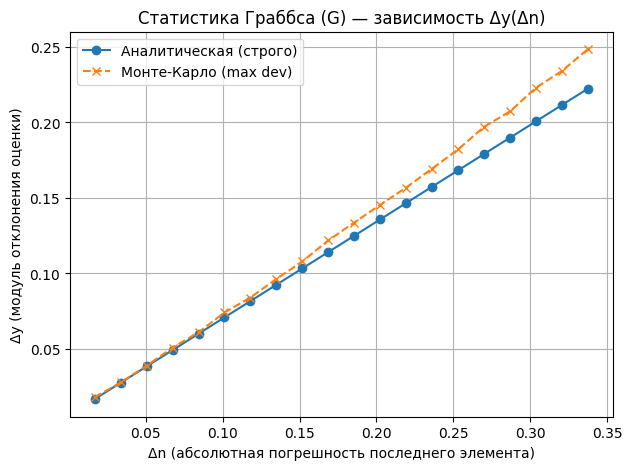

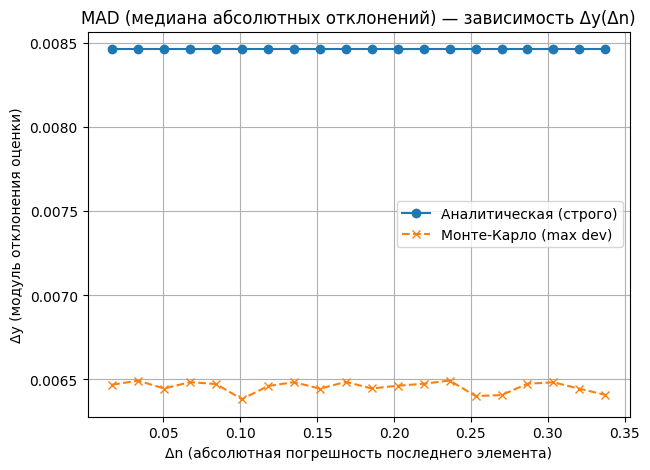

In [8]:
Delta_n = rel_last_values * abs(x0[-1])  # абсолютная Δn по последнему элементу

titles = {
    'sigma': "Среднеквадратическое отклонение (σ)",
    'mae': "Среднее абсолютное отклонение (MAE)",
    'grubbs': "Статистика Граббса (G)",
    'mad': "MAD (медиана абсолютных отклонений)"
}

for stat in ['sigma','mae','grubbs','mad']:
    plt.figure(figsize=(7,5))
    plt.title(f"{titles[stat]} — зависимость Δy(Δn)")
    plt.plot(Delta_n, analytic_res[stat], label="Аналитическая (строго)", marker='o')
    plt.plot(Delta_n, mc_res[stat], label="Монте-Карло (max dev)", linestyle='--', marker='x')
    plt.xlabel("Δn (абсолютная погрешность последнего элемента)")
    plt.ylabel("Δy (модуль отклонения оценки)")
    plt.grid(True)
    plt.legend()
    plt.show()


### Повтор эксперимента с добавлением выбросов

выбросов: 1 — [3.0]
Δy при Δn(max) (аналитика / MC):
sigma  : analytic = 4.725002e-02 ; MC = 4.830884e-02
mae    : analytic = 4.644615e-02 ; MC = 4.195757e-02
grubbs : analytic = 4.842436e-02 ; MC = 1.042911e-01
mad    : analytic = 1.213658e-01 ; MC = 1.162362e-01


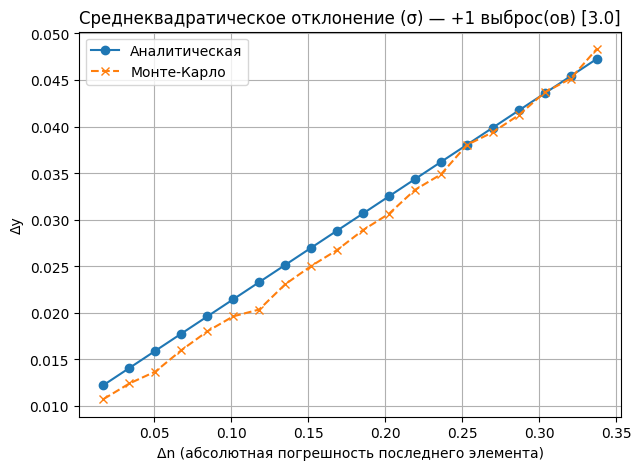

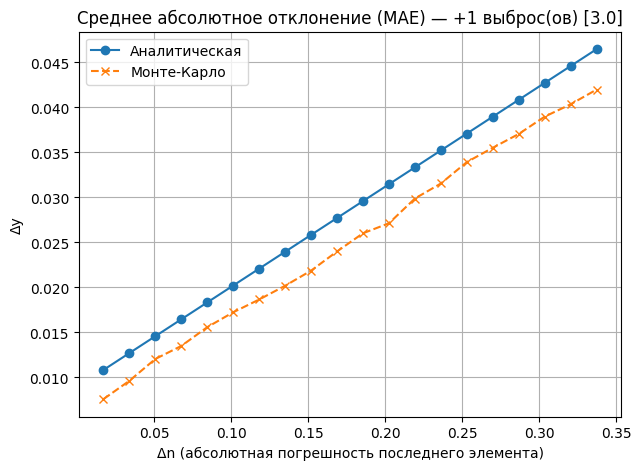

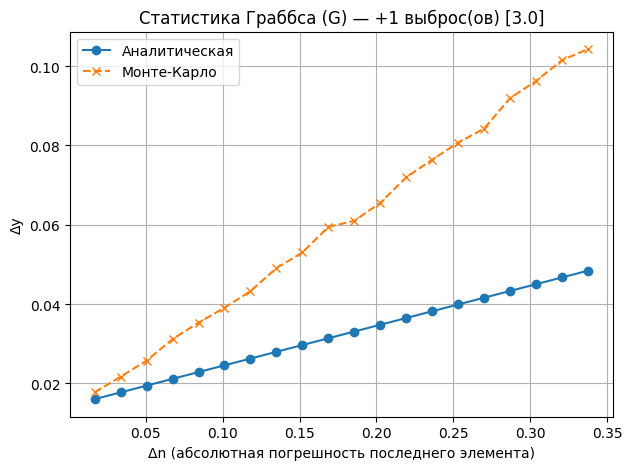

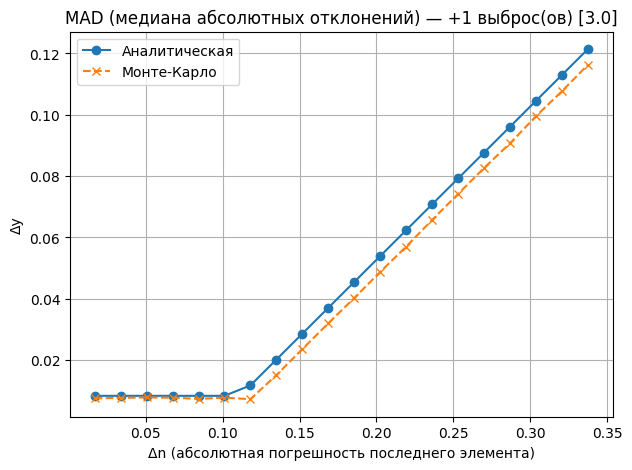

выбросов: 2 — [3.0, -2.5]
Δy при Δn(max) (аналитика / MC):
sigma  : analytic = 4.765327e-02 ; MC = 4.589395e-02
mae    : analytic = 4.075626e-02 ; MC = 4.249412e-02
grubbs : analytic = 4.059701e-02 ; MC = 3.413138e-02
mad    : analytic = 1.740082e-01 ; MC = 1.689943e-01


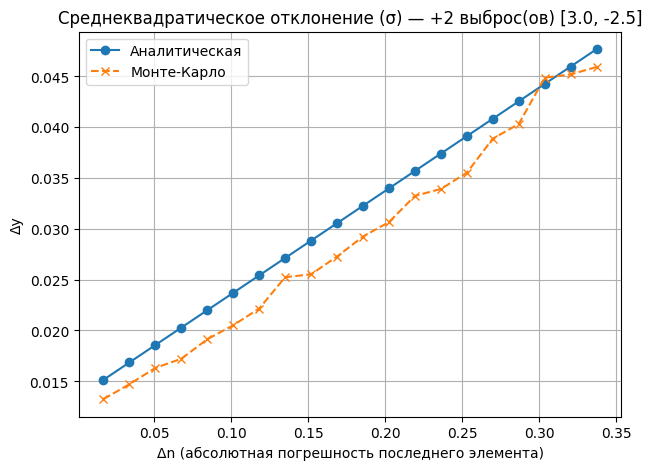

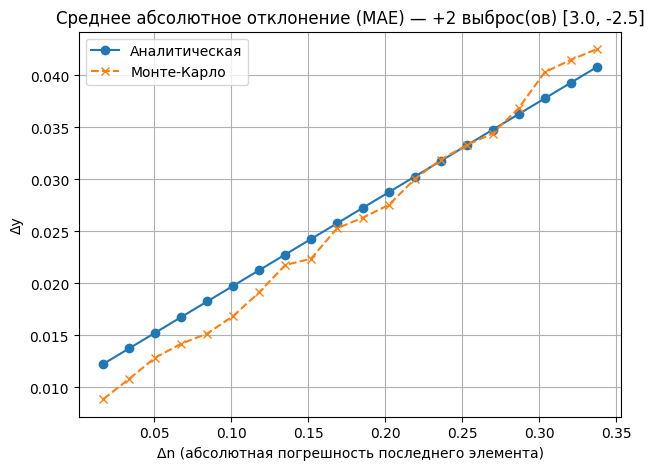

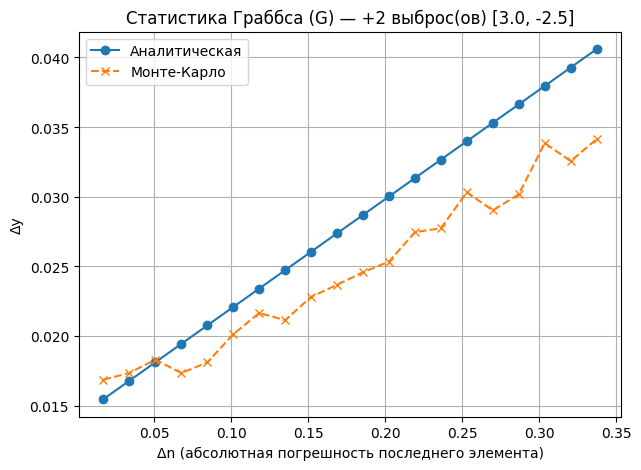

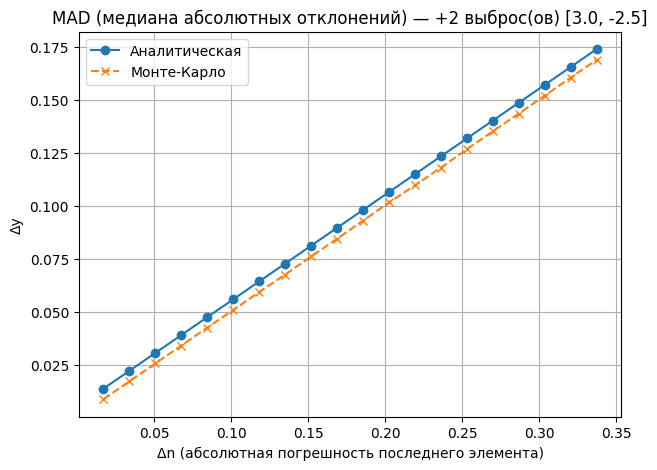

выбросов: 3 — [3.0, -2.5, 2.8]
Δy при Δn(max) (аналитика / MC):
sigma  : analytic = 3.869499e-02 ; MC = 3.641524e-02
mae    : analytic = 4.228414e-02 ; MC = 4.107841e-02
grubbs : analytic = 3.735431e-02 ; MC = 2.257804e-02
mad    : analytic = 1.759919e-01 ; MC = 1.690179e-01


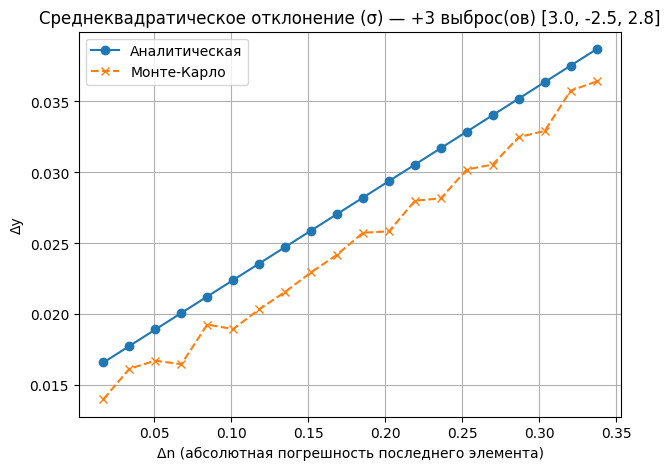

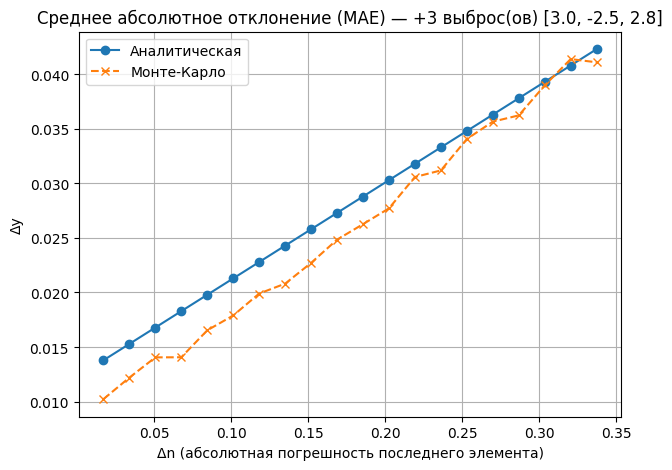

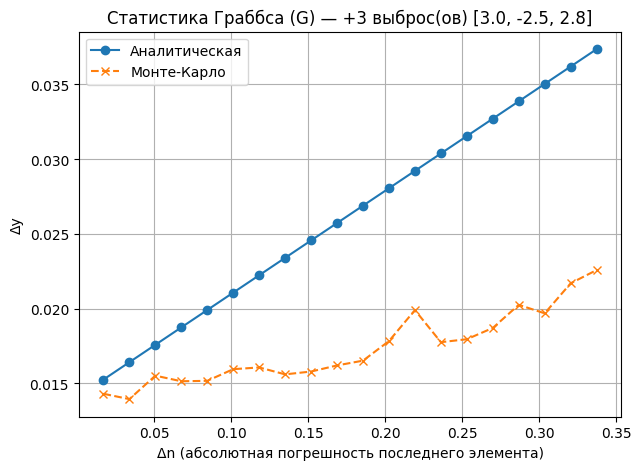

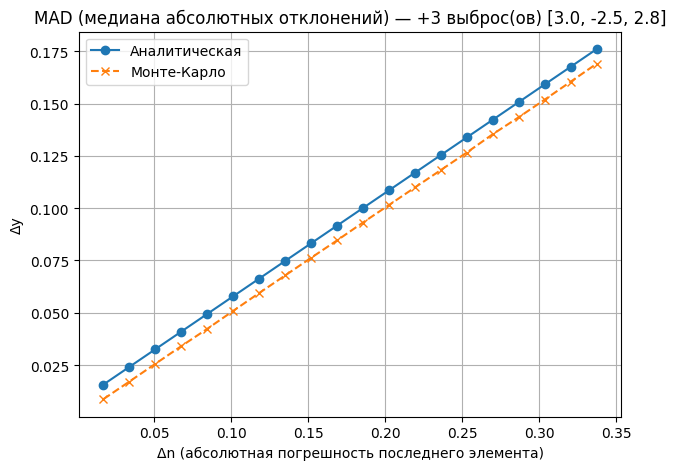

In [9]:
# выбросоы
extra_values_list = [
    [3.0],
    [3.0, -2.5],
    [3.0, -2.5, 2.8]
]

for extras in extra_values_list:
    print(f"выбросов: {len(extras)} — {extras}")

    # формируем модифицированную совокупность: заменим первые len(extras) элементов
    x_mod = x0.copy()
    x_mod[:len(extras)] = extras

    analytic_ex = {s: [] for s in ['sigma','mae','grubbs','mad']}
    mc_ex = {s: [] for s in ['sigma','mae','grubbs','mad']}

    for rel_last in rel_last_values:
        deltas = make_delta_vector(x_mod, rel_default=rel_default, rel_last=rel_last)

        an = analytic_delta_y_strict(x_mod, deltas)
        for s in analytic_ex:
            analytic_ex[s].append(an[s]['delta'])

        _, max_dev = monte_carlo_delta_y_lab6(x_mod, deltas, N=int(N_mc/2), seed=2, progress=False)
        for s in mc_ex:
            mc_ex[s].append(max_dev[s])

    # печать значений при максимальном Δn
    print("Δy при Δn(max) (аналитика / MC):")
    for s in ['sigma','mae','grubbs','mad']:
        print(f"{s:7s}: analytic = {analytic_ex[s][-1]:.6e} ; MC = {mc_ex[s][-1]:.6e}")

    # графики
    Delta_n_mod = rel_last_values * abs(x_mod[-1])
    for stat in ['sigma','mae','grubbs','mad']:
        plt.figure(figsize=(7,5))
        plt.title(f"{titles[stat]} — +{len(extras)} выброс(ов) {extras}")
        plt.plot(Delta_n_mod, analytic_ex[stat], label="Аналитическая", marker='o')
        plt.plot(Delta_n_mod, mc_ex[stat], label="Монте-Карло", linestyle='--', marker='x')
        plt.xlabel("Δn (абсолютная погрешность последнего элемента)")
        plt.ylabel("Δy")
        plt.grid(True)
        plt.legend()
        plt.show()


### а)Какая из оценок центра совокупности наименее робастная? Какая – наиболее робастная?

#### Наименее: ско сильно реагирует на большие отклонения так как использует квадрат разности. Также статистика Граббса имеет маленькую робастность ведь она специально сфокусирована на макс отклонении от среднего (поэтому любая ошибка в  выбросе мгновенно попадает в знаменатель и делает оценку более нестабильной)

#### Наиболее: Медиана абсолютных отклонений(MAD) игнорирует влияние крайних значений. Также среднее абсолютное отклонение(mae) т.к оно линейное, а не квадратичное в отличие от ско

### б) Сравните преимущества и недостатки оценки разброса в совокупности при использовании среднеквадратического отклонения и MAD.

#### СКО наименее робастная по сравнению с MAD. MAD практически неизменный, даже если в выборке есть сильные выбросы

#### При отсутствии выбросов ско более информативен

#### В нормальном распределении все таки лучше использовать ско